# Analysis of mondal2023cell2doc

In this notebook we analyse the outputs of the cells from the Cell2Doc dataset. Outputs can have 3 `output_type`:

1. `"stream"`: this indicates that the output was printed to stdout (since we did not collect outputs printed to stderr), the output will always be plain text.
2. `"display_data"` or `"execute_result"` these can have plain text and png outputs.

We are interested in finding missed opportunies in outputs that may have been analysed manually. For `display_data` and `execute_result` the output may simply be from the last statement in the cell. Thus we cannot be certain if the output was used for testing something manually.

Print statements on the other hand are very intentional, here we can be sure that the developer wanted to see the output (possibly to test/monitor/debug something).

In [1]:
import pandas as pd
import ast
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

sns.set_theme(context="talk", style="whitegrid", palette="colorblind")

In [7]:
# NOTE: takes 23s to execute
outputs = pd.read_csv(
    "data/shome2023notebook/mondal2023cell2doc-outputs.csv",
    header=None,
    names=["notebook", "source", "output_type", "text", "image", "has_html"],
    usecols=lambda x: x in ["notebook", "source", "output_type", "text"],
    # engine="pyarrow",
)
# outputs = outputs.loc[outputs["text/plain"].notna()]
outputs.head()

,notebook,source,output_type,text
1.0,data/mondal2023cell2doc/Cell2Doc-Artifacts/Rep...,import numpy as np \nimport pandas as pd \n\...,stream,Train with outlier:\nr2: 0.574804890299\nrmse:...
2.0,data/mondal2023cell2doc/Cell2Doc-Artifacts/Rep...,import matplotlib.pyplot as plt\n\n%matplotlib...,display_data,<matplotlib.figure.Figure at 0x7fc474ebb7b8>
4.0,data/mondal2023cell2doc/Cell2Doc-Artifacts/Rep...,train_labels = pd.read_csv('../input/prostate-...,execute_result,image_id data_provi...
8.0,data/mondal2023cell2doc/Cell2Doc-Artifacts/Rep...,%time biopsy = openslide.OpenSlide(path)\n%tim...,stream,"CPU times: user 482 µs, sys: 9.86 ms, total: 1..."
9.0,data/mondal2023cell2doc/Cell2Doc-Artifacts/Rep...,"%timeit img = biopsy.get_thumbnail(size=(331, ...",stream,190 ms ± 3.56 ms per loop (mean ± std. dev. of...


In [157]:
outputs = outputs.loc[outputs["output_type"] == "stream"]
outputs = outputs.dropna()
outputs.shape

(33556, 6)

## Data Pre-processing

Lets remove cells that do not have a valid AST.

**NOTE** This will remove cells that contain (very)magic commands as well.

In [6]:
def get_ast(source: str) -> ast.Module:
    try:
        tree = ast.parse(source)
    except SyntaxError:
        tree = None
    finally:
        return tree

In [9]:
outputs.loc[:, "ast"] = outputs["source"].apply(get_ast)
outputs = outputs.loc[outputs["ast"].notna()]
outputs.shape

<unknown>:6: SyntaxWarning: invalid escape sequence '\D'
<unknown>:3: SyntaxWarning: invalid escape sequence '\D'
<unknown>:96: SyntaxWarning: invalid escape sequence '\D'
<unknown>:96: SyntaxWarning: invalid escape sequence '\D'
<unknown>:4: SyntaxWarning: invalid escape sequence '\('
<unknown>:10: SyntaxWarning: invalid escape sequence '\.'
<unknown>:12: SyntaxWarning: invalid escape sequence '\!'
<unknown>:14: SyntaxWarning: invalid escape sequence '\?'
<unknown>:16: SyntaxWarning: invalid escape sequence '\,'
<unknown>:7: SyntaxWarning: invalid escape sequence '\-'
<unknown>:7: SyntaxWarning: invalid escape sequence '\-'
<unknown>:11: SyntaxWarning: invalid escape sequence '\.'
<unknown>:11: SyntaxWarning: invalid escape sequence '\.'
<unknown>:12: SyntaxWarning: invalid escape sequence '\.'
<unknown>:7: SyntaxWarning: invalid escape sequence '\-'
<unknown>:8: SyntaxWarning: invalid escape sequence '\-'
<unknown>:8: SyntaxWarning: invalid escape sequence '\*'
<unknown>:9: SyntaxWar

(33556, 5)

# Analysis of `print` statements

+ How many cells with print statements vs. without?
+ avg. number of print statements in a cell?
+ top nodes in the arguments of the print statement?
+ top functions used inside print statements?
+ analysis of the strings used inside print statement?
+ TODO: now many cells have implicit vs. explicit `print` statements?

In [20]:
class PrintCollector(ast.NodeVisitor):
    def __init__(self):
        self.nodes = []

    def visit_Call(self, node):
        if (isinstance(node.func, ast.Name) and node.func.id == "print"):
            self.nodes.append(node)

nodes = []

for _, tree in outputs["ast"].items():
    collector = PrintCollector()
    collector.generic_visit(tree)
    nodes.append(collector.nodes)
outputs.loc[:, "print_nodes"] = pd.Series(data=nodes)

In [43]:
print(f"cells w/o print statements: {len(outputs.loc[outputs["print_nodes"].apply(lambda x: len(x) == 0)])}")
print(f"cells w/ print statements: {len(outputs.loc[outputs["print_nodes"].apply(lambda x: len(x) > 0)])}")

cells w/o print statements: 11583
cells w/ print statements: 21973


We hae 11K cells which produced an output in stdout but did not contain a print statement. This means that they likely called a function which internally produces an output to stdout (probably also through a print statement, but we don't have access to the source code in the cell itself).

Majority of the cells do contain a print statement.

<Axes: ylabel='print_nodes'>

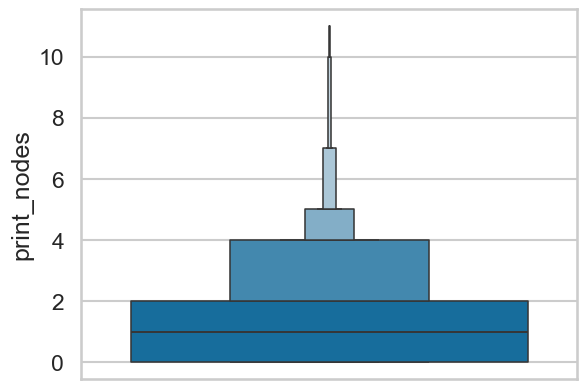

In [50]:
# NOTE: distribution of number of print statements in our data
sns.boxenplot(data=outputs["print_nodes"].apply(lambda x: len(x)))

In [40]:
# NOTE: print random sample of print statements
prints = outputs["print_nodes"].explode().dropna()
for id, node in prints.sample(10).items():
    print(ast.unparse(node))

print('Done: %.1fs' % (time.time() - t0))
print('Training')
print('Done: %.1fs' % (time.time() - t0))
print(os.listdir('../input'))
print('Train data: ', len(train_index))
print('Train without outlier:')
print('train_dataset', len(trainDataset), 'valid_dataset', len(validDataset))
print(df_trn['IsTemp'].value_counts())
print('Done: %.1fs' % (time.time() - t0))
print(df_trn['IsTemp'].value_counts())


In [71]:
prints.shape

(45792,)

## Anatomy of `print` statements

Similar to Assertions, we need to understand the anatomy of print statements to identify if and how they are being used for testing in ML notebooks.

The analysis can be broken down into two segments:

1. Analysis of the natural text written inside print statements (using NLP techniques)
2. And analysis of the source code inside print statements.

Print statements appear as a `ast.Call` node where `Call.func` is a `Name` node and `Name.id == 'print'`. The arguments of the print statement are inside `Call.args`.

The natural language text appear as `ast.Constant` nodes.

### Analysis of natural language text in print statements

In [64]:
tests = [
    "print('a constant only', 'and another')",
    "print(f'a constant in f string {foo}')",
    "print('a formatted string with {} and {}'.format(foo, bar))"
]
for test in tests:
    print("==========")
    print("SOURCE:\n")
    print(test)
    print("AST:\n")
    print(ast.dump(ast.parse(test), indent=4))

SOURCE:

print('a constant only', 'and another')
AST:

Module(
    body=[
        Expr(
            value=Call(
                func=Name(id='print', ctx=Load()),
                args=[
                    Constant(value='a constant only'),
                    Constant(value='and another')],
                keywords=[]))],
    type_ignores=[])
SOURCE:

print(f'a constant in f string {foo}')
AST:

Module(
    body=[
        Expr(
            value=Call(
                func=Name(id='print', ctx=Load()),
                args=[
                    JoinedStr(
                        values=[
                            Constant(value='a constant in f string '),
                            FormattedValue(
                                value=Name(id='foo', ctx=Load()),
                                conversion=-1)])],
                keywords=[]))],
    type_ignores=[])
SOURCE:

print('a formatted string with {} and {}'.format(foo, bar))
AST:

Module(
    body=[
        Expr(
            

In [70]:
class StringCollector(ast.NodeVisitor):
    def __init__(self):
        self.corpus = []

    def visit_Constant(self, node):
        if isinstance(node.value, str):
            self.corpus.append(node.value)

collector = StringCollector()
for _, node in prints.items():
    collector.visit(node)

len(collector.corpus)

43580

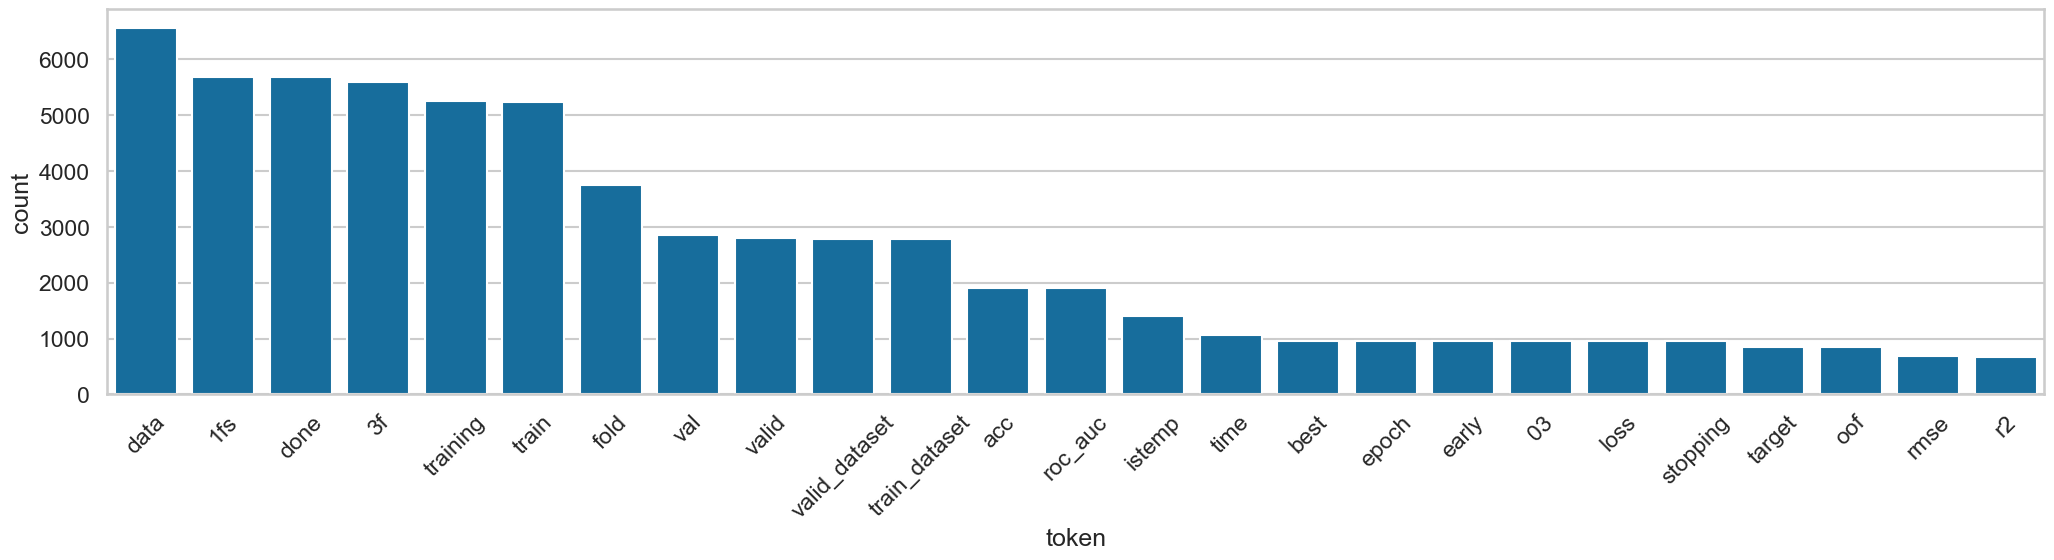

In [113]:
vectorizer = CountVectorizer(
    preprocessor=None,  # default, lowercase and ignore punctuations
    stop_words=None,  # default, experiment with 'english'
    analyzer="word",  # default
    ngram_range=(1, 1),  # default, experiment with bigrams (2,2)
)
X = vectorizer.fit_transform(collector.corpus)
occurances = pd.DataFrame(
    data={"token": vectorizer.get_feature_names_out(), "count": X.toarray().sum(axis=0)}
)

fig, ax = plt.subplots(figsize=(25, 5))
sns.barplot(
    data=occurances.sort_values(by=["count"], ascending=False).head(25),
    x="token",
    y="count",
    ax=ax,
)
ax.tick_params(axis='x', rotation=45)

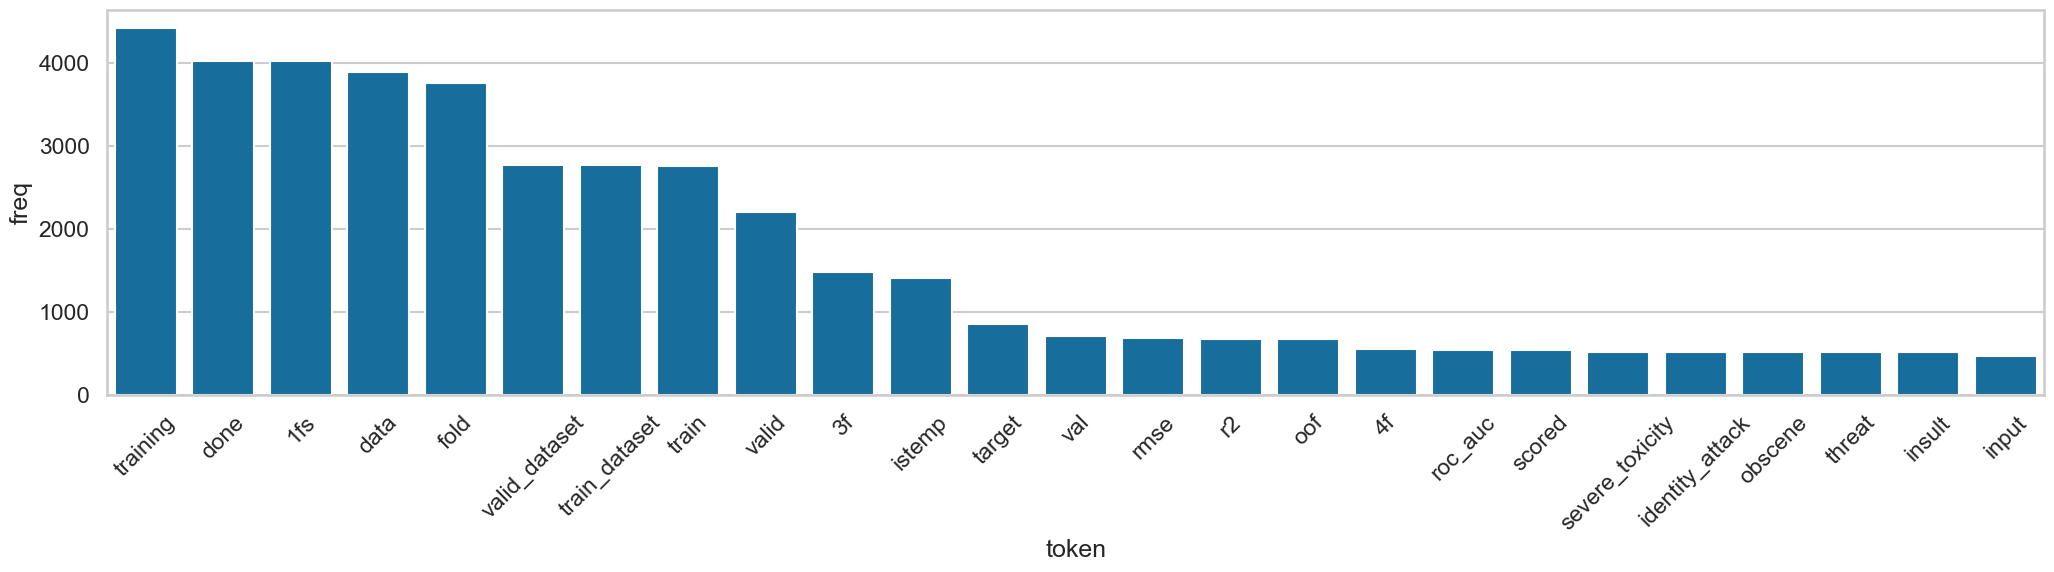

In [112]:
vectorizer = TfidfVectorizer(
    preprocessor=None,  # default
    stop_words=None,  # default
    analyzer='word',  # default
    ngram_range=(1,1),  # default
)
X = vectorizer.fit_transform(collector.corpus)
frequences = pd.DataFrame(
    data = {"token": vectorizer.get_feature_names_out(), "freq": X.toarray().sum(axis=0)}
)

fig, ax = plt.subplots(figsize=(25, 5))
sns.barplot(
    data=frequences.sort_values(by=["freq"], ascending=False).head(25),
    x="token",
    y="freq",
    ax=ax,
)
ax.tick_params(axis='x', rotation=45)

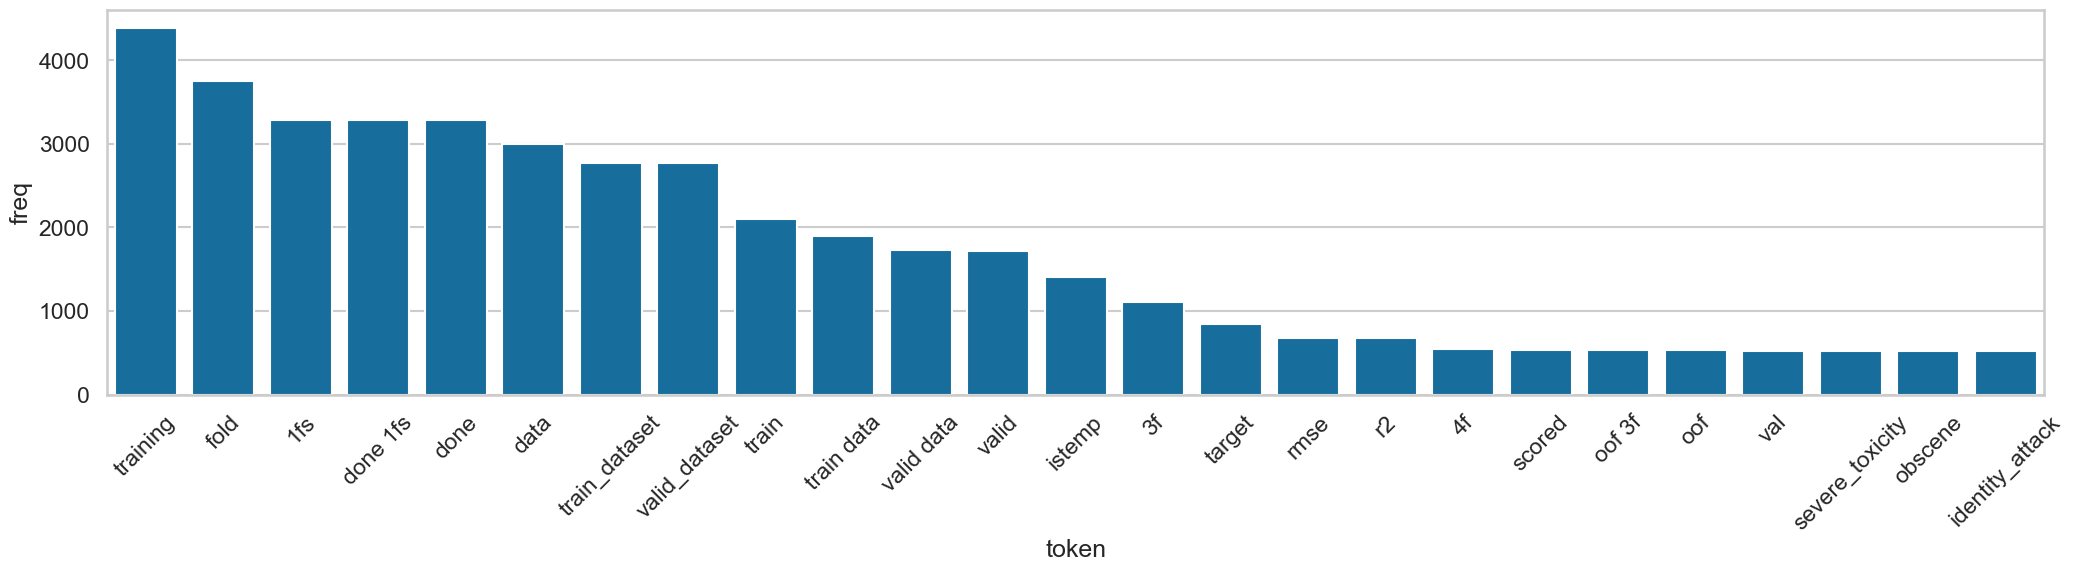

In [115]:
vectorizer = TfidfVectorizer(
    preprocessor=None,  # default
    stop_words=None,  # default
    analyzer='word',  # default
    ngram_range=(1,2),  # mono and bi-grams
)
X = vectorizer.fit_transform(collector.corpus)
frequences = pd.DataFrame(
    data = {"token": vectorizer.get_feature_names_out(), "freq": X.toarray().sum(axis=0)}
)

fig, ax = plt.subplots(figsize=(25, 5))
sns.barplot(
    data=frequences.sort_values(by=["freq"], ascending=False).head(25),
    x="token",
    y="freq",
    ax=ax,
)
ax.tick_params(axis='x', rotation=45)

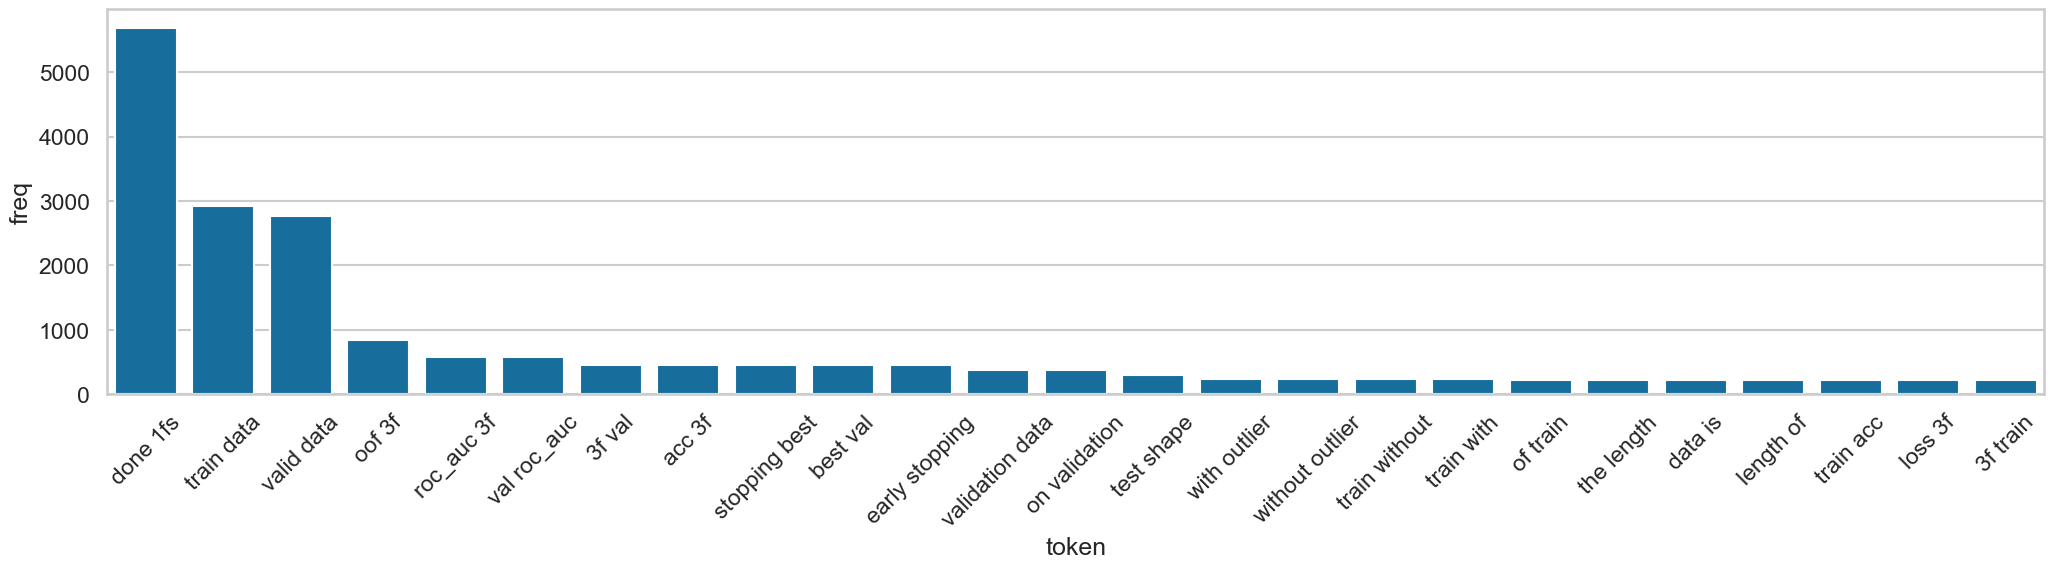

In [114]:
vectorizer = TfidfVectorizer(
    preprocessor=None,  # default
    stop_words=None,  # default
    analyzer='word',  # default
    ngram_range=(2,2),  # bi-grams
)
X = vectorizer.fit_transform(collector.corpus)
frequences = pd.DataFrame(
    data = {"token": vectorizer.get_feature_names_out(), "freq": X.toarray().sum(axis=0)}
)

fig, ax = plt.subplots(figsize=(25, 5))
sns.barplot(
    data=frequences.sort_values(by=["freq"], ascending=False).head(25),
    x="token",
    y="freq",
    ax=ax,
)
ax.tick_params(axis='x', rotation=45)

### Analysis of function calls inside print statements

Here, we want to analyse the function calls which were passed as argument to the print statements.

In [125]:
tests = [
    "print(foo(x,y))",
    "print(baz.foo(x,y))",
    "print(bar.baz.foo(x,y))",
    "print('something to print{}'.format(foo))",
    "print('something to print{}'.format(foo(x, y)))"
]

for test in tests:
    print("==========")
    print("SOURCE:\n")
    print(test)
    print("AST:\n")
    print(ast.dump(ast.parse(test), indent=4))

SOURCE:

print(foo(x,y))
AST:

Module(
    body=[
        Expr(
            value=Call(
                func=Name(id='print', ctx=Load()),
                args=[
                    Call(
                        func=Name(id='foo', ctx=Load()),
                        args=[
                            Name(id='x', ctx=Load()),
                            Name(id='y', ctx=Load())],
                        keywords=[])],
                keywords=[]))],
    type_ignores=[])
SOURCE:

print(baz.foo(x,y))
AST:

Module(
    body=[
        Expr(
            value=Call(
                func=Name(id='print', ctx=Load()),
                args=[
                    Call(
                        func=Attribute(
                            value=Name(id='baz', ctx=Load()),
                            attr='foo',
                            ctx=Load()),
                        args=[
                            Name(id='x', ctx=Load()),
                            Name(id='y', ctx=Load())],
        

<Axes: xlabel='count', ylabel='print_nodes'>

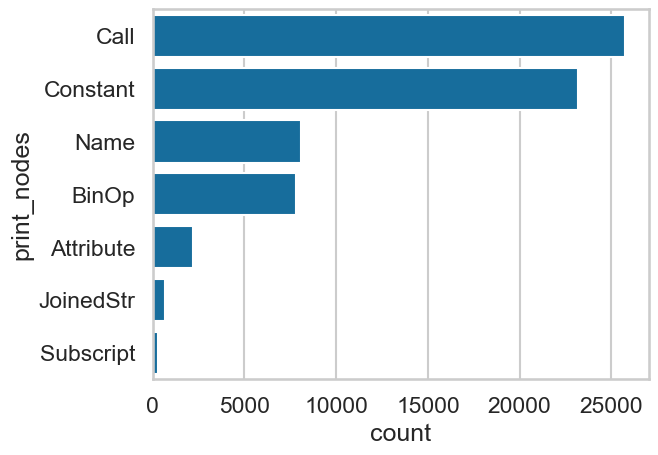

In [132]:
args = prints.apply(lambda x: x.args)
args = args.explode().dropna()

sns.barplot(
    data=args.apply(lambda x: x.__class__.__name__)
    .value_counts()
    .sort_values(ascending=False),
    orient="h",
)

In [133]:
indices = args.apply(lambda x: x.__class__.__name__ == 'Call')
calls = args.loc[indices]
calls.shape

(25758,)

In [43]:
# NOTE: NameCollector will ignore format function calls (since it never hits a Name node), analyse them separately.
class NameCollector(ast.NodeVisitor):
    def __init__(self):
        self.name = None
        self.stack = []

    def visit_Name(self, node: ast.Name) -> None:
        if self.stack:
            self.name = (node.id, self.stack[0].attr)
        else:
            self.name = (None, node.id)

    def visit_Attribute(self, node: ast.Attribute) -> None:
        self.stack.append(node)
        self.visit(node.value)

In [ ]:
names = []
for _, node in calls.items():
    collector = NameCollector()
    collector.visit(node.func)
    names.append(collector.name)

names = pd.DataFrame(data=names, columns=["module", "function"])
names.shape

<Axes: xlabel='count', ylabel='function'>

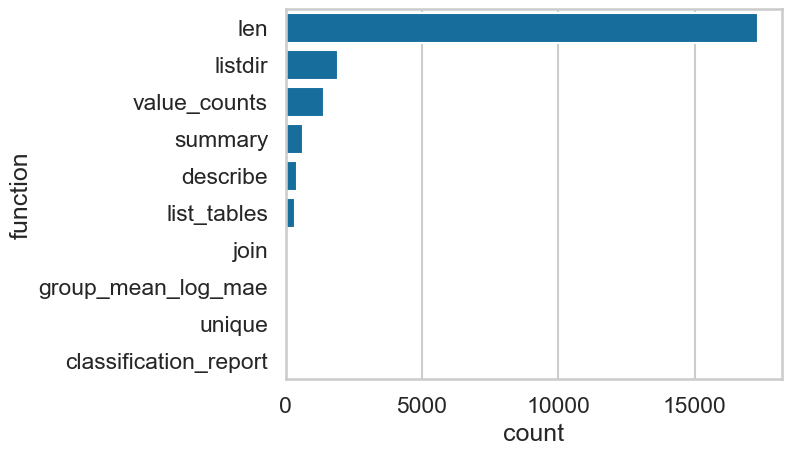

In [155]:
sns.barplot(
    data=names["function"].dropna().value_counts().sort_values(ascending=False).head(10),
    orient='h'
)

# Analysis of implicit outputs

In this section we analyse `output_type == 'execute_result'`. These are the outputs generated from the list line of a code cell. Our hypothesis here is that this is a form of manual test.

Our heuristic here is simple: cells that produce an output are considered tests, cells that don't are not.

From the AST perspective, the output is produced by the last top-level node of the tree.

In [3]:
outputs = pd.read_csv(
    "data/shome2023notebook/mondal2023cell2doc-outputs.csv",
    header=None,
    names=["notebook", "source", "output_type", "text", "image", "has_html"],
    usecols=lambda x: x in ["notebook", "source", "output_type", "text", "has_html"],
    engine="c",
)
outputs = outputs.loc[outputs["output_type"] == "execute_result"]
outputs = outputs.dropna()
outputs.head()

,notebook,source,output_type,text,has_html
4.0,data/mondal2023cell2doc/Cell2Doc-Artifacts/Rep...,train_labels = pd.read_csv('../input/prostate-...,execute_result,image_id data_provi...,True
3.0,data/mondal2023cell2doc/Cell2Doc-Artifacts/Rep...,tr = pd.read_csv(path + 'train.csv')\nprint(tr...,execute_result,ImageId_ClassId ...,True
4.0,data/mondal2023cell2doc/Cell2Doc-Artifacts/Rep...,df = tr[tr['ImageId_ClassId'].apply(lambda x: ...,execute_result,ImageId_ClassId\n0 0002cc93b.jpg\n1 0003...,True
7.0,data/mondal2023cell2doc/Cell2Doc-Artifacts/Rep...,df_trn = pd.concat([df[~df['ImageId_ClassId']....,execute_result,ImageId_ClassId IsTemp\n0 0002cc93b.jpg ...,True
2.0,data/mondal2023cell2doc/Cell2Doc-Artifacts/Rep...,# Now we have 3 sets of features\ngrid_df = pd...,execute_result,id item_i...,True


In [7]:
outputs.loc[:, "ast"] = outputs["source"].apply(get_ast)
outputs = outputs.loc[outputs["ast"].notna()]
outputs.shape

<unknown>:5: SyntaxWarning: invalid escape sequence '\s'
<unknown>:1: SyntaxWarning: invalid escape sequence '\w'
<unknown>:4: SyntaxWarning: invalid escape sequence '\.'
<unknown>:3: SyntaxWarning: invalid escape sequence '\.'
<unknown>:1: SyntaxWarning: invalid escape sequence '\|'
<unknown>:3: SyntaxWarning: invalid escape sequence '\('
<unknown>:5: SyntaxWarning: invalid escape sequence '\s'


(9294, 6)

In [8]:
outputs.loc[:, "last_node"] = outputs["ast"].apply(lambda x: x.body[-1])
outputs["last_node"].isna().any()

False

In [17]:
# NOTE: random sample of last nodes
for _, node in outputs["last_node"].sample(5).items():
    print("==========")
    print("SOURCE:\n")
    print(ast.unparse(node))
    print("AST:\n")
    print(ast.dump(node, indent=4))

SOURCE:

texts.head()
AST:

Expr(
    value=Call(
        func=Attribute(
            value=Name(id='texts', ctx=Load()),
            attr='head',
            ctx=Load()),
        args=[],
        keywords=[]))
SOURCE:

train[c_cols].head()
AST:

Expr(
    value=Call(
        func=Attribute(
            value=Subscript(
                value=Name(id='train', ctx=Load()),
                slice=Name(id='c_cols', ctx=Load()),
                ctx=Load()),
            attr='head',
            ctx=Load()),
        args=[],
        keywords=[]))
SOURCE:

TweetData.head()
AST:

Expr(
    value=Call(
        func=Attribute(
            value=Name(id='TweetData', ctx=Load()),
            attr='head',
            ctx=Load()),
        args=[],
        keywords=[]))
SOURCE:

dominant_topic.head(5)
AST:

Expr(
    value=Call(
        func=Attribute(
            value=Name(id='dominant_topic', ctx=Load()),
            attr='head',
            ctx=Load()),
        args=[
            Constant(value=5)]

In [21]:
# NOTE: most frequent node
outputs["last_node"].apply(lambda x: x.__class__.__name__).value_counts().sort_values(ascending=False)

last_node
Expr      9261
For         32
Assign       1
Name: count, dtype: int64

In [26]:
# NOTE: for loops should not produce this type of output; investigate:
fors = outputs.loc[outputs["last_node"].apply(lambda x: x.__class__.__name__ == "For")]
for _, row in fors.sample(5).iterrows():
    print("==========")
    print("SOURCE:\n")
    print(ast.unparse(row.last_node))
    print("OUTPUT:\n")
    print(row.text)

SOURCE:

for team, f in top_submissions.items():
    s = pd.read_csv(f)
    s = s.merge(test_w2, on='ForecastId')
    s = s[['Location', 'Date', 'ConfirmedCases', 'Fatalities']]
    predictions = predictions.merge(s, on=['Location', 'Date'], suffixes=['', f' ({team})'], how='outer')
    s.shape
    s.tail(2)
OUTPUT:

        Location        Date  ConfirmedCases  Fatalities
12640  Zimbabwe-  2020-04-29       51.113476    6.948775
12641  Zimbabwe-  2020-04-30       52.010480    7.056078
SOURCE:

for team, f in top_submissions.items():
    s = pd.read_csv(f)
    s = s.merge(test_w3, on='ForecastId')
    s = s[['Location', 'Date', 'ConfirmedCases', 'Fatalities']]
    predictions = predictions.merge(s, on=['Location', 'Date'], suffixes=['', f' ({team})'], how='outer')
    s.shape
    s.tail(2)
OUTPUT:

        Location        Date  ConfirmedCases  Fatalities
13156  Zimbabwe-  2020-05-06           39.17      10.290
13157  Zimbabwe-  2020-05-07           40.99      10.755
SOURCE:

for team, f

In [29]:
for _ in range(5):
    outputs.tail()
    outputs.shape
    outputs.head()

Interesting, with the current version of notebooks, there is no output from `for` loops, maybe the examples above are from an older version of notebook?

Analyse the Expr nodes next.

In [34]:
class ExprCollector(ast.NodeVisitor):
    def __init__(self):
        self.nodes = []

    def visit_Expr(self, node: ast.Expr) -> None:
        self.nodes.append(node)

collector = ExprCollector()
outputs["last_node"].apply(lambda x: collector.visit(x))
exprs = pd.Series(data=collector.nodes)
exprs.shape


(9364,)

In [35]:
# NOTE: top nodes inside Expr

exprs.map(lambda x: x.value.__class__.__name__).value_counts().sort_values(ascending=False)

Call         7806
Name          944
Subscript     471
Attribute     132
BinOp           7
Tuple           3
Compare         1
Name: count, dtype: int64

In [40]:
indices = exprs.map(lambda x: x.value.__class__.__name__ == "Name")
names = exprs.loc[indices].map(lambda x: x.value)
names.map(lambda x: x.id).value_counts().sort_values(ascending=False)


df                34
submission        29
train_df          26
train             26
test_df           23
                  ..
sell_price_avg     1
india              1
sample_df          1
qtp                1
df_scores          1
Name: count, Length: 487, dtype: int64

These are most likely to be the names of the dataframes/series used in the notebooks. It is expected that "df", "train_df", "train" and "test_df" are the most common. The fact that "submission" is second, indicates that we have many educational notebooks in our population.

Lets analyse the function calls next.

In [42]:
indices = exprs.map(lambda x: x.value.__class__.__name__ == "Call")
calls = exprs.loc[indices].map(lambda x: x.value)
calls.shape

(7806,)

In [44]:
names = []
for _, node in calls.items():
    collector = NameCollector()
    collector.visit(node.func)
    names.append(collector.name)

names = pd.DataFrame(data=names, columns=["module", "function"])
names

,module,function
0,train_labels,head
1,tr,head
2,df,head
3,df_trn,head
4,grid_df,head
...,...,...
7801,X_val,head
7802,X_test,head
7803,train,head
7804,submission_df,head


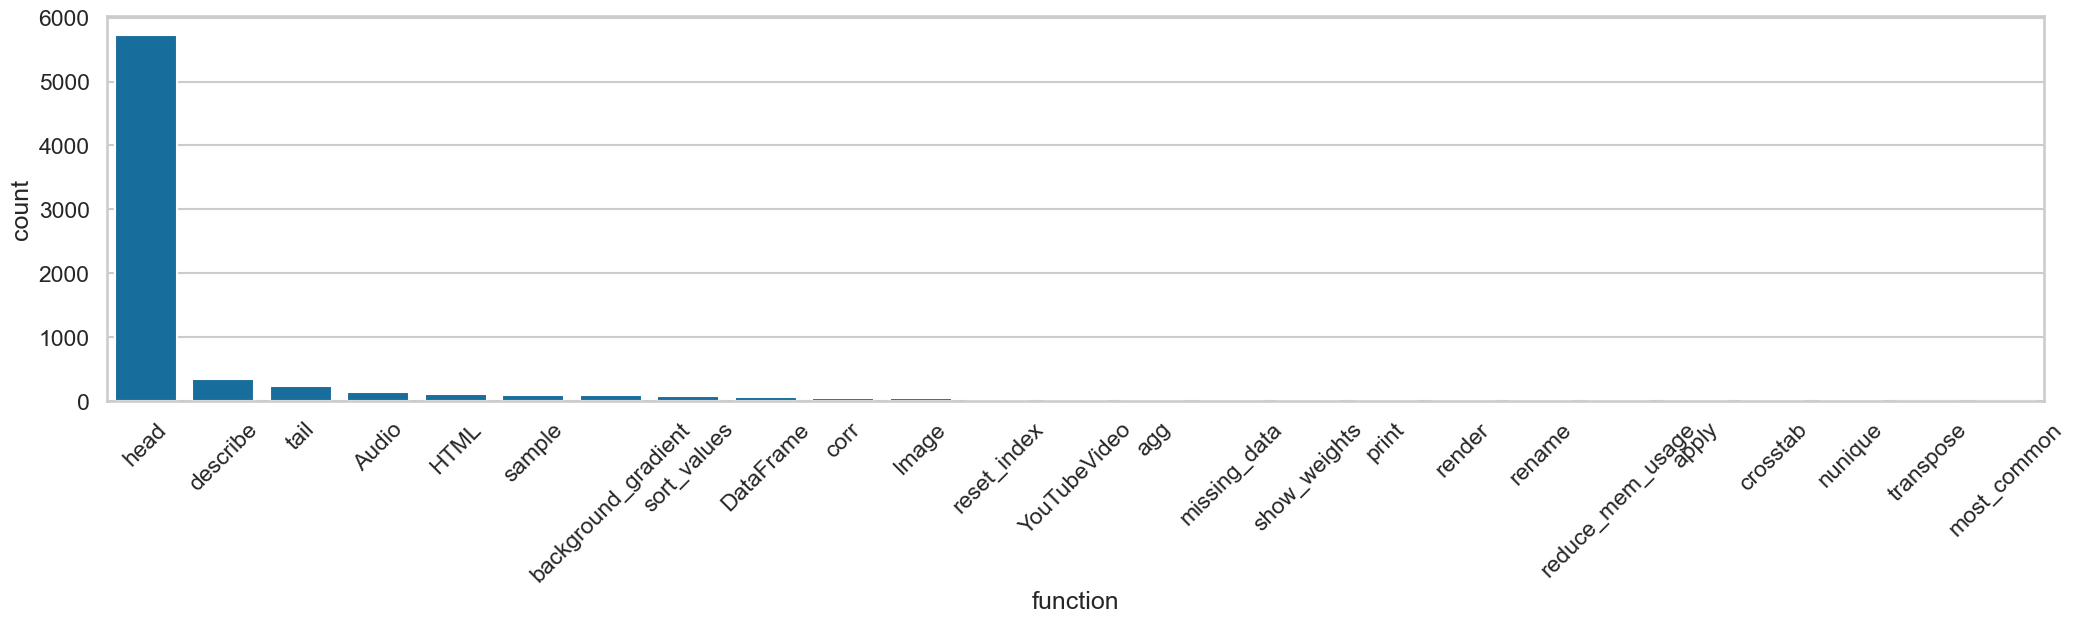

In [47]:
fix, ax = plt.subplots(figsize=(25, 5))
sns.barplot(
    data=names["function"].value_counts().sort_values(ascending=False).head(25),
    ax=ax,
)
ax.tick_params(axis='x', rotation=45)


In this case, looking at the most frequent method is probably not useful. We want to see the less common method calls.

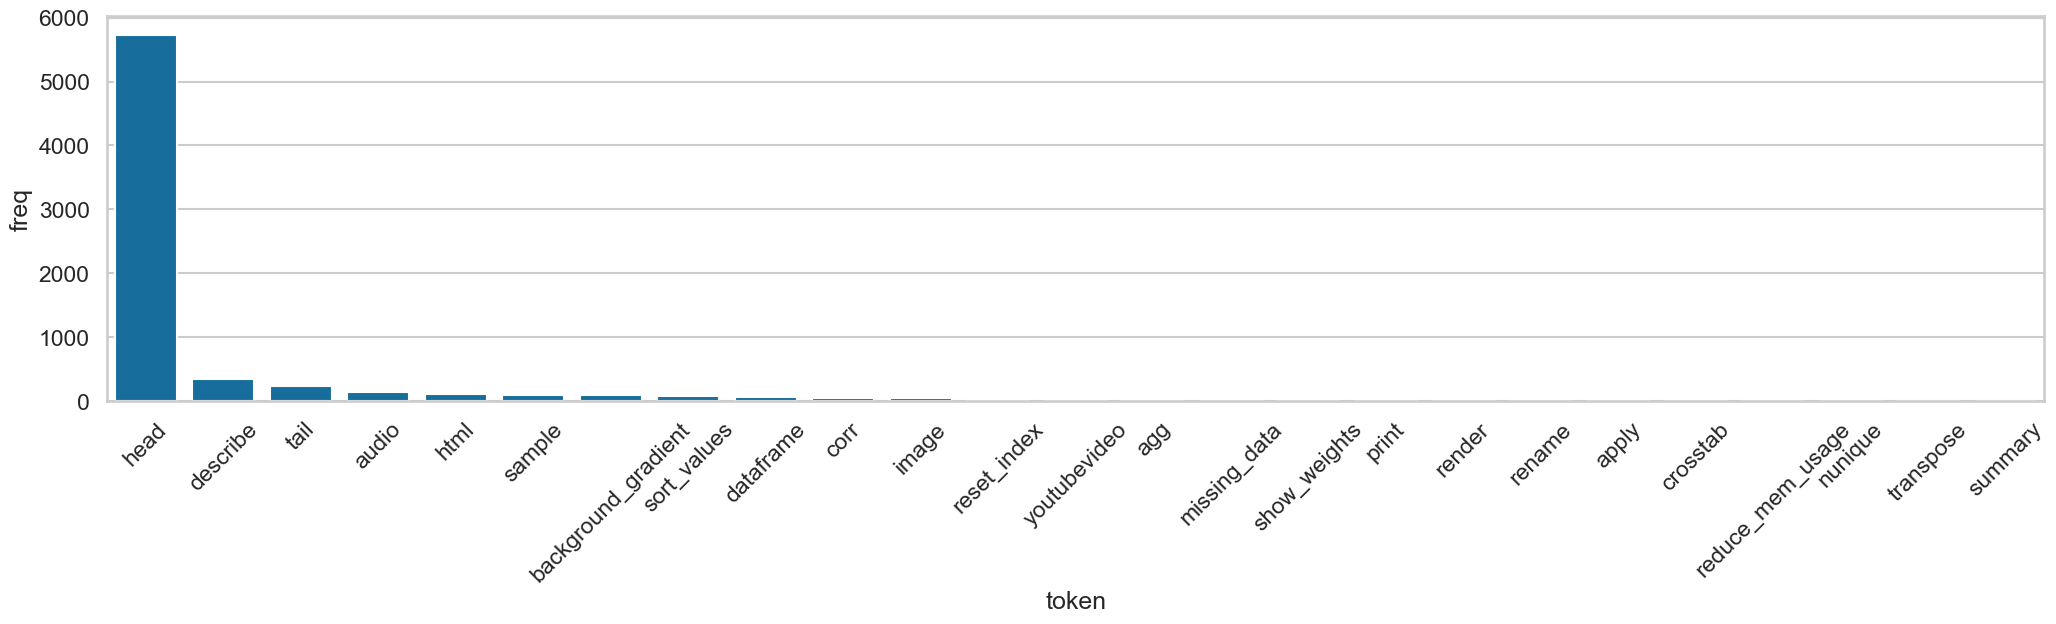

In [76]:
# NOTE: I think Tfidf does not work here, because we have "documents" consisting of only 1 word so term frequency is always 1? And then somehow, dividing the term frequency with inverse document frequency results back in the occurances again?
vectorizer = TfidfVectorizer(
    preprocessor=None,
    stop_words=None,
    analyzer="word",
    ngram_range=(1,1),
)
X = vectorizer.fit_transform(names["function"])
frequencies = pd.DataFrame(
    data = {"token": vectorizer.get_feature_names_out(), "freq": X.toarray().sum(axis=0)}
)

fig, ax = plt.subplots(figsize=(25, 5))
sns.barplot(
    data=frequencies.sort_values(by=["freq"], ascending=False).head(25),
    x="token",
    y="freq",
    ax=ax,
)
ax.tick_params(axis='x', rotation=45)

**Observations**

**NEXT**: The most frequent methods are usually used to check that something worked. In these, cases, it would be useful to analyse the code that preceeds the function call.

**NEXT**: The less frequent method calls are also interesting (such as `agg` and `corr`). I have seen assertions that check for correlation. Perhaps we can do a targetted analysis of these nodes as well?

# Analysis of visualisations

In this section we perform descriptive and lexical analysis of code cells that produce a visualisation output.

In this analysis we focus on visualisations created using matplotlib and seaborn since those libraries are the most popular for creating notebooks.

We focus our analysis only on the line in the source code that produces the visualisation. We collect the top level module (if available), the function used (which indicates the type of plot), and the arguments passed.

We make the following specifications:

1. We look for the module abbreviations as per the official tutorials (`sns` for seaborn and `plt` for matplotlib)
2. We only collect visualisations produced using the functional style of programming (rather than object oriented); I vaguely remember there was a paper/blogpost that analysed this aspect

Seaborn is fairly straightforward to parse:

+ It has figure level functions: `relplot`, `displot` & `catplot` where we need to look at the `type` argument to know the exact figure type.
+ otherwise its a direct function call: `sns.histplot`

For matplotlib, we assume that the figure is created using the recommended way in the tutorial: `fig, ax = plt.subplots()`. Then we only look for the `ax.plot` type statements.

In [6]:
tests = [
    "sns.histplot(data=df, x='x', y='y')",
    "sns.distplot(data=df, x='x', y='y', type='hist')",
    "ax.plot(x, y)",
]

for test in tests:
    print("==========")
    print("SOURCE:\n")
    print(test)
    print("AST:\n")
    print(ast.dump(ast.parse(test), indent=4))

SOURCE:

sns.histplot(data=df, x='x', y='y')
AST:

Module(
    body=[
        Expr(
            value=Call(
                func=Attribute(
                    value=Name(id='sns', ctx=Load()),
                    attr='histplot',
                    ctx=Load()),
                args=[],
                keywords=[
                    keyword(
                        arg='data',
                        value=Name(id='df', ctx=Load())),
                    keyword(
                        arg='x',
                        value=Constant(value='x')),
                    keyword(
                        arg='y',
                        value=Constant(value='y'))]))],
    type_ignores=[])
SOURCE:

sns.distplot(data=df, x='x', y='y', type='hist')
AST:

Module(
    body=[
        Expr(
            value=Call(
                func=Attribute(
                    value=Name(id='sns', ctx=Load()),
                    attr='distplot',
                    ctx=Load()),
                args=[],
      

In [83]:
# NOTE: takes 23s to execute
visualisations = pd.read_csv(
    "data/shome2023notebook/mondal2023cell2doc-outputs.csv",
    header=None,
    names=["notebook", "source", "output_type", "text", "image", "has_html"],
    usecols=lambda x: x in ["notebook", "source", "output_type", "image"],
    engine="c",
)
visualisations = visualisations.loc[visualisations["image"].notna()]
visualisations.shape

(38397, 4)

In [84]:
visualisations.loc[:, "ast"] = visualisations["source"].apply(get_ast)
visualisations = visualisations.loc[visualisations["ast"].notna()]
visualisations.shape

<unknown>:2: SyntaxWarning: invalid escape sequence '\l'
<unknown>:4: SyntaxWarning: invalid escape sequence '\l'
<unknown>:3: SyntaxWarning: invalid escape sequence '\l'
<unknown>:5: SyntaxWarning: invalid escape sequence '\l'
<unknown>:26: SyntaxWarning: invalid escape sequence '\D'
<unknown>:7: SyntaxWarning: invalid escape sequence '\$'
<unknown>:7: SyntaxWarning: invalid escape sequence '\$'
<unknown>:2: SyntaxWarning: invalid escape sequence '\d'
<unknown>:11: SyntaxWarning: invalid escape sequence '\$'
<unknown>:11: SyntaxWarning: invalid escape sequence '\$'
<unknown>:84: SyntaxWarning: invalid escape sequence '\$'
<unknown>:84: SyntaxWarning: invalid escape sequence '\$'
<unknown>:84: SyntaxWarning: invalid escape sequence '\$'
<unknown>:84: SyntaxWarning: invalid escape sequence '\$'
<unknown>:84: SyntaxWarning: invalid escape sequence '\$'
<unknown>:13: SyntaxWarning: invalid escape sequence '\D'
<unknown>:16: SyntaxWarning: invalid escape sequence '\D'
<unknown>:18: SyntaxW

(37787, 5)

In [124]:
class FunctionCollector(ast.NodeVisitor):
    def __init__(self):
        self.nodes = []

    def visit_Call(self, node: ast.Call) -> None:
        if isinstance(node.func, ast.Attribute):
            if isinstance(node.func.value, ast.Name):
                node.func.value.id in ["sns", "ax"] and self.nodes.append(node)


In [125]:
collector = FunctionCollector()
for _, node in visualisations["ast"].items():
    collector.visit(node)

calls = pd.Series(data=collector.nodes)
calls.shape

(20097,)

We have to modify the previous `NameCollector` class since we need to handle figure-level functions for seaborn.

seaborn has 3 figure-level functions: `displot`, `relplot` & `catplot`. We need to look at the `kind` argument for these functions to extract the actual function name.

In [126]:
# NOTE: the overrides the previous definiton of NoteCollector
# this one is a bit more complex, to handle the names of visualisation methods
class NameCollector(ast.NodeVisitor):
    def __init__(self):
        self.name = None

    def visit_Call(self, node: ast.Call) -> None:
        if node.func.attr in ["displot", "relplot", "catplot"]:
            for keyword in node.keywords:
                self.visit_keyword(keyword, type=node.func.attr) # this goes to keyword nodes
        else:
            self.visit(node.func) # this goes to Attribute node; usual case


    def visit_Attribute(self, node: ast.Attribute) -> None:
        self.name = node.attr

    def visit_keyword(self, node: ast.keyword, type: str) -> None:
        if node.arg == "kind":
            self.name = node.value.value
        else:
            match type:
                case "displot":
                    self.name = "hist"
                case "relplot":
                    self.name = "scatter"
                case "catplot":
                    self.name = "strip"


In [127]:
names = []
for _, node in calls.items():
    collector = NameCollector()
    collector.visit(node)
    names.append(collector.name)

names = pd.Series(data=names)
names

0          kdeplot
1        countplot
2        countplot
3        countplot
4        countplot
           ...    
20092      barplot
20093      barplot
20094          set
20095     pairplot
20096      heatmap
Length: 20097, dtype: object

In [128]:
names.value_counts().sort_values(ascending=False)

distplot     4841
kdeplot      2413
heatmap      1403
countplot    1343
set_title    1269
             ... 
count           1
clabel          1
contour         1
contourf        1
reshape         1
Name: count, Length: 114, dtype: int64

We can clean up the output with the following pre-processing tasks:

1. handling deprecated method: I see `distplot` a lot which is deprecated since seaborn v.0.14. Based on the [migration guide](https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751) provided by the creator of seaborn, `distplot` is similar to `histplot`, so we make this change in our dataset
3. `plot`, `scatter` and `scatterplot` are all the same. Name them all `scatter`
4. Remove the "plot" from the end of the function names, then functions across matplotlib and seaborn which perform the same visualisation, will be merged together

In [129]:
names.loc[names.map(lambda x: x == "displot")] = "histplot"
names.loc[names.map(lambda x: x == "plot")] = "scatter"
names.loc[names.map(lambda x: "plot" in x)] = names.loc[
    names.map(lambda x: "plot" in x)
].str.rstrip("plot")

In [130]:
names.value_counts().sort_values(ascending=False)

dis          4841
kde          2413
heatmap      1403
coun         1343
set_title    1269
             ... 
count           1
clabel          1
contour         1
contourf        1
reshape         1
Name: count, Length: 110, dtype: int64

In [38]:
# NOTE: remove helper functions
names = names.loc[
    ~names["function"]
    .str.lower()
    .str.contains("add|ax[(is)|(.line)]?|annotate|despine|format|grid|params|palette|set|get|style|text|legend", regex=True)
]
names.shape

(15055, 2)

<Axes: xlabel='count', ylabel='function'>

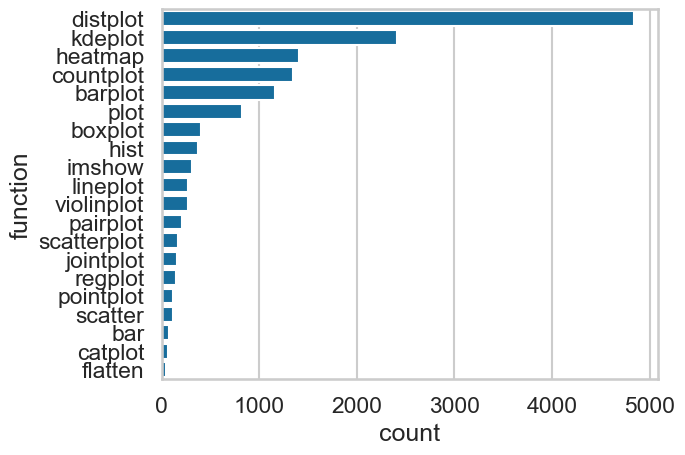

In [42]:
sns.barplot(
    data=names["function"].value_counts().sort_values(ascending=False).head(20),
    orient='h'
)

<Axes: xlabel='count', ylabel='function'>

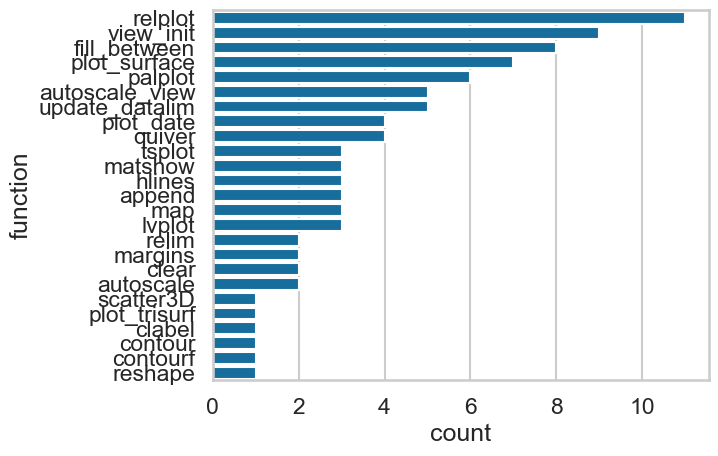

In [40]:
sns.barplot(
    data=names["function"].value_counts().sort_values(ascending=False).tail(25),
    orient='h'
)